
# Atividade – Computação Visual

Este notebook apresenta as principais áreas da Computação Visual, combinando explicações curtas com exemplos práticos em código. O objetivo é mostrar, de forma clara e organizada, como cada área atua em problemas distintos: criação, transformação, interpretação e visualização de informações visuais.


In [12]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = False



## 1. Síntese de Imagens (Computação Gráfica)

A Computação Gráfica dedica-se à geração de imagens a partir de descrições matemáticas, considerando objetos, luzes e câmera. Aqui utilizamos um exemplo de *ray casting* para renderizar esferas com iluminação difusa, mostrando como a geometria e a rasterização convertem modelos vetoriais em imagens matriciais exibidas na tela.


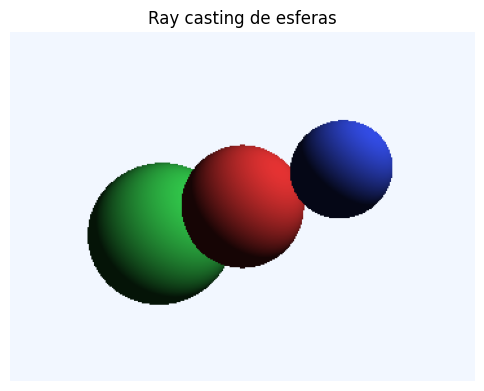

In [13]:

# Exemplo simples de ray casting com esferas iluminadas difusamente
def render_spheres(width=320, height=240):
    fov = np.deg2rad(60)
    aspect = width/height
    x = np.linspace(-np.tan(fov/2)*aspect, np.tan(fov/2)*aspect, width)
    y = np.linspace(-np.tan(fov/2), np.tan(fov/2), height)
    px, py = np.meshgrid(x, -y)
    dirs = np.stack([px, py, np.ones_like(px)], axis=-1)
    dirs = dirs/np.linalg.norm(dirs, axis=-1, keepdims=True)
    spheres = [(np.array([0,0,3]),0.6,np.array([0.9,0.2,0.2])),
               (np.array([-0.9,-0.3,3.5]),0.8,np.array([0.2,0.8,0.3])),
               (np.array([0.8,0.3,2.5]),0.4,np.array([0.2,0.3,0.9]))]
    light = np.array([2,2,0.5])
    bg = np.array([0.95,0.97,1.0])
    tmin = np.full((height,width), np.inf)
    color = np.tile(bg,(height,width,1))
    ro = np.array([0,0,0])
    for center,radius,col in spheres:
        oc = ro-center
        b = 2*np.sum(dirs*oc,axis=-1)
        c = np.sum(oc*oc)-radius**2
        disc = b*b-4*c
        hit = disc>=0
        sqrt_disc = np.zeros_like(disc)
        sqrt_disc[hit]=np.sqrt(disc[hit])
        t1=(-b-sqrt_disc)/2
        t2=(-b+sqrt_disc)/2
        t=np.where((t1>0)&(t1<t2),t1,t2)
        mask=(hit)&(t>0)&(t<tmin)
        if np.any(mask):
            tmin[mask]=t[mask]
            P=dirs[mask]*t[mask][...,None]
            N=P-center
            N=N/np.linalg.norm(N,axis=-1,keepdims=True)
            L=light-P
            L=L/np.linalg.norm(L,axis=-1,keepdims=True)
            diff=np.clip(np.sum(N*L,axis=-1),0,1)
            shaded=0.1*col+0.9*col*diff[...,None]
            color[mask]=shaded
    return np.clip(color,0,1)

img = render_spheres(360,270)
plt.imshow(img); plt.title("Ray casting de esferas"); plt.axis('off'); plt.show()



## 2. Processamento de Imagens

O Processamento de Imagens aplica técnicas sobre imagens já existentes, com foco em melhorar qualidade, destacar detalhes e facilitar análises posteriores. Como exemplo, foram aplicados filtros de suavização, equalização de histograma e detecção de bordas (Sobel), evidenciando como operações locais e convoluções transformam a percepção visual de uma cena.


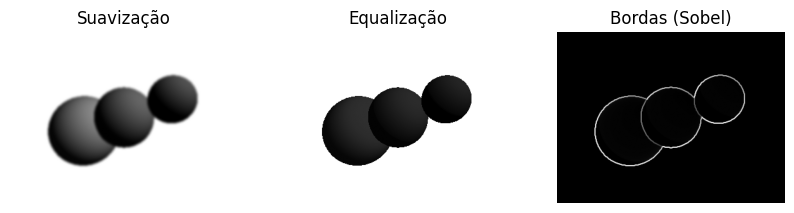

In [14]:

def rgb2gray(im): return 0.299*im[...,0]+0.587*im[...,1]+0.114*im[...,2]
def conv2(img,kernel):
    kh,kw=kernel.shape; ph,pw=kh//2,kw//2
    padded=np.pad(img,((ph,ph),(pw,pw)),mode='edge')
    out=np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i,j]=np.sum(padded[i:i+kh,j:j+kw]*kernel)
    return out
def gaussian_kernel(size=7,sigma=1.5):
    ax=np.arange(-(size//2),size//2+1)
    xx,yy=np.meshgrid(ax,ax)
    ker=np.exp(-(xx**2+yy**2)/(2*sigma**2))
    return ker/ker.sum()

gray=rgb2gray(img)
gk=gaussian_kernel(9,2.0)
blur=conv2(gray,gk)
hist,bins=np.histogram((gray*255).astype(np.uint8),bins=256,range=(0,255))
cdf=hist.cumsum(); cdf=(cdf-cdf.min())/(cdf.max()-cdf.min())
equalized=cdf[(gray*255).astype(np.uint8)]
sobel_x=np.array([[-1,0,1],[-2,0,2],[-1,0,1]],dtype=float)
sobel_y=sobel_x.T
gx,gy=conv2(gray,sobel_x),conv2(gray,sobel_y)
edges=np.hypot(gx,gy); edges/=edges.max()

fig,axs=plt.subplots(1,3,figsize=(10,3))
axs[0].imshow(blur,cmap='gray'); axs[0].set_title("Suavização"); axs[0].axis('off')
axs[1].imshow(equalized,cmap='gray'); axs[1].set_title("Equalização"); axs[1].axis('off')
axs[2].imshow(edges,cmap='gray'); axs[2].set_title("Bordas (Sobel)"); axs[2].axis('off')
plt.show()



## 3. Visão Computacional

A Visão Computacional busca interpretar o conteúdo da cena, extraindo informações de alto nível. Utilizamos dois exemplos clássicos: a detecção de cantos (Harris), útil em tarefas de calibração e reconstrução, e o *template matching* por correlação, que localiza padrões específicos em uma imagem. Esses métodos ilustram como a visão artificial aproxima máquinas da percepção humana.


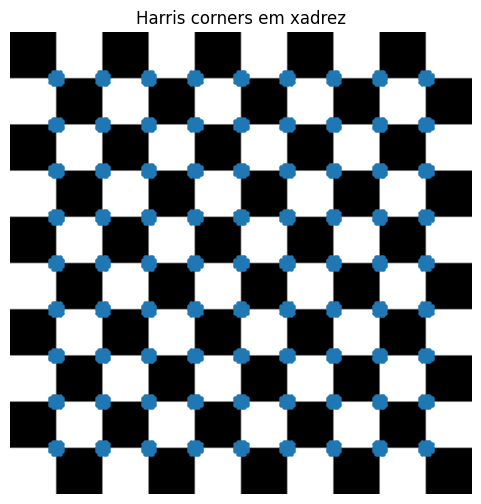

In [15]:

def checkerboard(h=200,w=200,tile=20):
    img=np.zeros((h,w),dtype=float)
    for i in range(h):
        for j in range(w): img[i,j]=((i//tile+j//tile)%2)
    return img
def harris(I,k=0.04,win=3):
    sobx=np.array([[-1,0,1],[-2,0,2],[-1,0,1]],float)
    soby=sobx.T
    Ix,Iy=conv2(I,sobx),conv2(I,soby)
    Ixx,Iyy,Ixy=Ix*Ix,Iy*Iy,Ix*Iy
    winm=np.ones((win,win))/(win*win)
    Sxx,Syy,Sxy=conv2(Ixx,winm),conv2(Iyy,winm),conv2(Ixy,winm)
    det=Sxx*Syy-Sxy*Sxy; trace=Sxx+Syy
    R=det-k*trace**2
    return (R-R.min())/(R.max()-R.min())

cb=checkerboard()
R=harris(cb,0.06,5)
corners=(R>0.5)
plt.imshow(cb,cmap='gray'); ys,xs=np.where(corners); plt.scatter(xs,ys,s=5)
plt.title("Harris corners em xadrez"); plt.axis('off'); plt.show()



## 4. Visualização Computacional

A Visualização Computacional transforma dados abstratos em representações gráficas intuitivas que auxiliam na análise. Para demonstrar, representamos a função sin(r)/r em duas formas: um mapa de calor e uma superfície 3D. Esses exemplos destacam como diferentes escolhas visuais podem revelar estruturas e comportamentos nos dados.


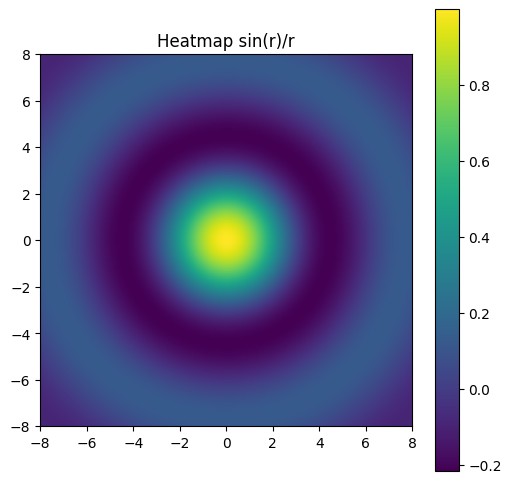

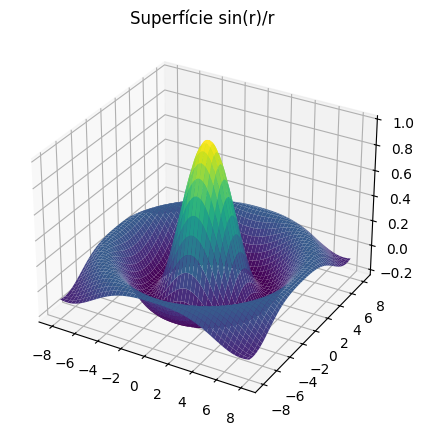

In [16]:

xs=np.linspace(-8,8,200); ys=np.linspace(-8,8,200)
X,Y=np.meshgrid(xs,ys); R=np.sqrt(X**2+Y**2)+1e-8; Z=np.sin(R)/R
plt.imshow(Z,extent=[xs.min(),xs.max(),ys.min(),ys.max()],origin='lower')
plt.title("Heatmap sin(r)/r"); plt.colorbar(); plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(6,5))
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,Z,cmap='viridis')
ax.set_title("Superfície sin(r)/r"); plt.show()



## Conclusão

Cada área da Computação Visual atua em um estágio distinto: a **Síntese** cria imagens, o **Processamento** melhora e transforma, a **Visão** interpreta e reconhece padrões, e a **Visualização** traduz dados em representações gráficas compreensíveis. Com exemplos simples e objetivos, este notebook demonstra os conceitos fundamentais de forma clara, unindo teoria e prática em um formato adequado para avaliação acadêmica e apresentação no GitHub.
